# Computer Vision Lecture - Exercise 6 - Self-Supervision
In this exercise, we will implement the Barlow Twins approach discussed in Lecture 11. We will learn self-supervised representations (with no labels!) on the CIFAR-10 dataset, and then use these representations to build a k-Nearest Neighbor classifier with very few labeled training samples.

This notebook guides you through the relevant steps. When you see helper functions, you don't need to do anything - they are already implemented. The functions you need to implement are indicated as Exercise Function. For this exercise, there are **four exercise functions** in total. When you are done, you can explore the approach in more detail if you like, by re-training the model with different augmentations and hyper-parameters.

Good luck!

*Remark*: If you encounter "IOPub message rate exceeded" while downloading the datasets, you can launch the notebook with the following extra flag:
`jupyter-notebook --NotebookApp.iopub_data_rate_limit=1.0e10`

Note that this is a one-time warning that may happen only the first time you execute the notebook. It is not an error with the dataset download, and will not appear again once the data is downloaded. 

## Preliminaries
Let's import the required libaries and datasets.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets

First, we download the [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html) and visualize some of its images.

Files already downloaded and verified
Total training examples: 50000
Total validation examples: 10000


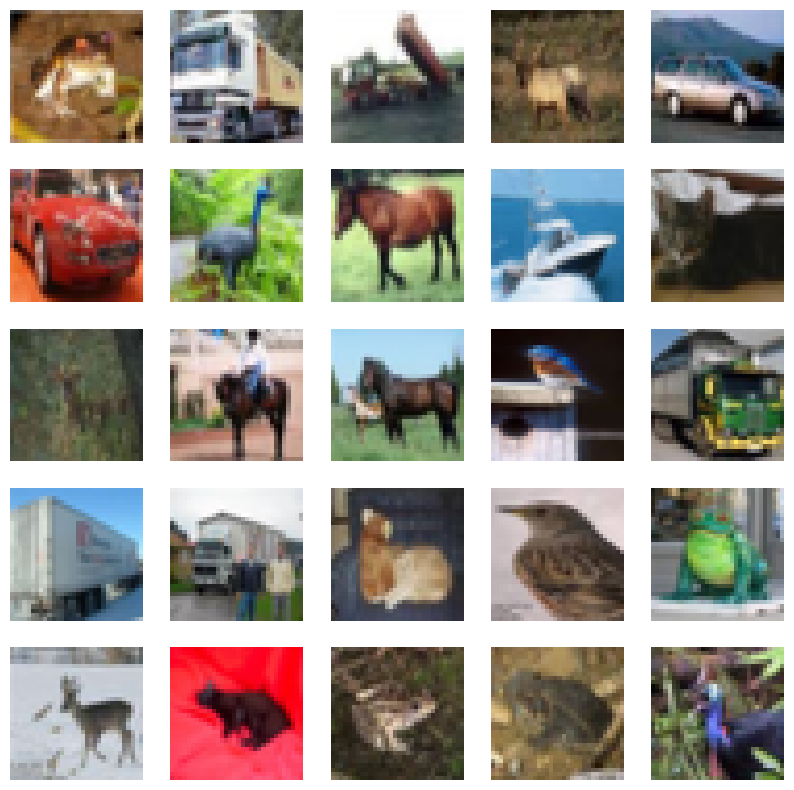

In [2]:
train_set = datasets.CIFAR10(root='./data', train=True, download=True)
val_set = datasets.CIFAR10(root='./data', train=False)
print(f"Total training examples: {len(train_set)}")
print(f"Total validation examples: {len(val_set)}")

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(np.asarray(train_set[n][0]).astype("int"))
    plt.axis("off")
plt.show()

## k-NN classifier for CIFAR-10

We now have our dataset. Let's start by trying to program a k-Nearest Neighbors (k-NN) classifier that directly uses the image pixels as features. k-NN classifiers are commonly used to evaluate the quality of a representation in self-supervised learning models. In particular, we will build our k-NN classifier using 1000 training images and 1000 testing images from the CIFAR-10 dataset. Note that the full size of the CIFAR-10 training set is 50000 images, so the k-NN classifiers we use in this exercise use only **2% of the available labels in the dataset**. Let's sub-sample our training and validation datasets for the k-NN classifier.

In [3]:
NUM_SAMPLES = 1000

# 1000 random (image, label) pairs from train set
train_indices = random.sample(range(len(train_set)), k=NUM_SAMPLES)
train_subset = train_set.data[train_indices]
train_subset_labels = np.array(train_set.targets)[train_indices]

# 1000 random (image, label) pairs from validation set
val_indices = random.sample(range(len(val_set)), k=NUM_SAMPLES)
val_subset = val_set.data[val_indices]
val_subset_labels = np.array(val_set.targets)[val_indices]

### k-NN prediction
The steps that we now have to take are:

1. For each validation sample, obtain the L1 distance to every training sample.
2. Filter the k training samples with the lowest L1 distance to each validation sample.
3. Check the labels of these k filtered training samples, and use a majority vote for classification

Implement the k-NN prediction function below.

In [4]:
###########################
#### Exercise Function ####
###########################
def predict_knn(sample, train_data, train_labels, k):
    '''
    returns the predicted label for a specific validation sample
    
    :param sample: single example from validation set
    :param train_data: full training set as a single array
    :param train_labels: full set of training labels and a single array
    :param k: number of nearest neighbors used for k-NN voting
    '''
    train_data = torch.tensor(train_data)
    train_labels = torch.tensor(train_labels)
    n = train_data.shape[0]
    distance = torch.sum(torch.tensor(abs(train_data - sample).reshape(n, -1)), dim=-1, keepdim=False)      # reshape to (n, ?) before sum
    _, k_index = torch.topk(distance, k, largest=False)
    k_label = train_labels[k_index]
    label, _ = torch.mode(k_label)
    label = np.array(label)
    return label

We will now compute the classification accuracy for the 3 different settings of k (7, 13, and 19).

In [5]:
predictions_7 = []
predictions_13 = []
predictions_19 = []
for sample in val_subset:
    predictions_7.append(predict_knn(sample, train_subset, train_subset_labels, k=7))
    predictions_13.append(predict_knn(sample, train_subset, train_subset_labels, k=13))
    predictions_19.append(predict_knn(sample, train_subset, train_subset_labels, k=19))

C:\Users\86156\AppData\Local\Temp\ipykernel_31652\1221243924.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance = torch.sum(torch.tensor(abs(train_data - sample).reshape(n, -1)), dim=-1, keepdim=False)      # reshape to (n, ?) before sum


In [6]:
matches_7 = (np.array(predictions_7) == val_subset_labels)
accuracy_7 = np.sum(matches_7)/NUM_SAMPLES * 100
print(f"k-NN accuracy (k=7): {accuracy_7}%")

matches_13 = (np.array(predictions_13) == val_subset_labels)
accuracy_13 = np.sum(matches_13)/NUM_SAMPLES * 100
print(f"k-NN accuracy (k=13): {accuracy_13}%")

matches_19 = (np.array(predictions_19) == val_subset_labels)
accuracy_19 = np.sum(matches_19)/NUM_SAMPLES * 100
print(f"k-NN accuracy (k=19): {accuracy_19}%")

k-NN accuracy (k=7): 18.0%
k-NN accuracy (k=13): 17.7%
k-NN accuracy (k=19): 17.299999999999997%


## Representation learning with Barlow Twins

We see that the k-NN classifier's accuracy is better than random guessing (which would give 10%). However, there is still room for improvement. Rather than classifying the RGB image pixels, we are now going to learn self-supervised representations for the CIFAR-10 images, without any of the training labels! Using the k-NN classifier on top of these self-supervised representations, we hope to boost the classifier's performance.

Barlow Twins is a contrastive learning approach that requires various kinds of **data augmentation**. We provide these for you through the following helper function. If you are interested, feel free to experiment with the hyper-parameters of this transform in order to get better results.

In [7]:
###########################
##### Helper Function #####
###########################
def get_transform():
    '''
    returns a transform that randomly crops, flips, jitters color or drops color from the input
    '''
    return transforms.Compose([
                transforms.RandomResizedCrop(32, scale=[0.75, 1.0], 
                                            interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                            saturation=0.2, hue=0.1)],
                    p=0.9
                ),
                transforms.RandomGrayscale(p=0.3),
            ])

### Augmented Data

Let's generate two versions of this transform (t1 and t2) and visualize some training images with the transforms applied. The self-supervised learning objective will require the network to match features coming from such transformed pairs. With the visualizations, we can ensure that these pairs indeed come from the same image, and observe the differences between the pair as a result of our augmentation choice. 

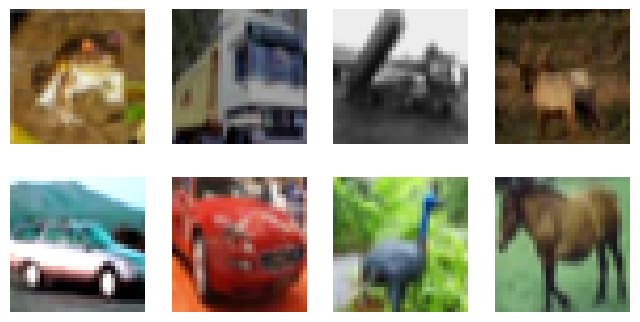

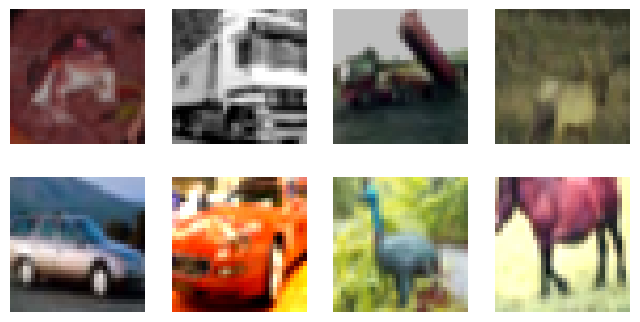

In [8]:
t1 = get_transform()
t2 = get_transform()

plt.figure(figsize=(8, 4))
for n in range(8):
    im_t1 = t1(train_set[n][0])
    plt.subplot(2, 4, n + 1)
    plt.imshow(np.asarray(im_t1).astype("int"))
    plt.axis("off")
plt.show()

plt.figure(figsize=(8, 4))
for n in range(8):
    im_t2 = t2(train_set[n][0])
    plt.subplot(2, 4, n + 1)
    plt.imshow(np.asarray(im_t2).astype("int"))
    plt.axis("off")
plt.show()

### Barlow Twins loss

The main crux of Barlow Twins lies in the way the authors formulate the loss function. Here's the overall pseudocode for Barlow Twins (taken from the [paper](https://arxiv.org/abs/2103.03230)). 

![](https://i.ibb.co/bJLRjzx/image.png)

You will now be implementing this loss function. If you feel stuck, please look through Section 2 the original paper, which provides additional mathematical details. We recommend that you first write a pytorch function to extract a flattened (1-dimensional) view of the off-diagonal elements of a square matrix, which will later be useful in implementing the complete loss function.

In [9]:
###########################
#### Exercise Function ####
###########################
def off_diagonal_naive(x):
    '''
    returns a flattened view of the off-diagonal elements of a square matrix x
    '''
    n, m = x.shape
    assert n == m
    off = torch.zeros(n, n-1)
    for i in range(n):
        if i == 0:
            off[i] = x[i][1:]
        elif i == n-1:
            off[i] = x[i][:n-1]
        else:
            off[i][:i] = x[i][:i]
            off[i][i:] = x[i][i+1:]

    return off.reshape(-1)

def off_diagonal(x):
    '''
    returns a flattened view of the off-diagonal elements of a square matrix x
    '''

    n, m = x.shape
    assert n == m

    flatten_x = x.flatten()
    x = flatten_x[:-1].reshape(n-1, n+1)    # remove the last element and reshape to (n-1, n+1), whose first column is the original diagonal
    return x[:, 1:].flatten()

In [10]:
test_x = torch.arange(9).reshape(3, 3)
print(test_x)
print(off_diagonal_naive(test_x))
print(off_diagonal(test_x))

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])
tensor([1., 2., 3., 5., 6., 7.])
tensor([1, 2, 3, 5, 6, 7])


In [31]:
###########################
#### Exercise Function ####
###########################
def barlow_loss(z1, z2, bn, lambd):
    '''
    return the barlow twins loss function for a pair of features. Makes use of the off_diagonal function.
    
    :param z1: first input feature
    :param z2: second input feature
    :param bn: nn.BatchNorm1d layer applied to z1 and z2
    :param lambd: trade-off hyper-parameter lambda
    '''
    
    N, D = z1.shape

    z1_norm = bn(z1)
    z2_norm = bn(z2)
    
    c = z1_norm.T @ z2_norm
    c.div_(N)
    assert (c.shape == torch.zeros([D, D]).shape)

    c_diff = (c - torch.eye(D).cuda()).pow(2)
    loss = torch.sum(off_diagonal(c_diff) * lambd)
    loss += torch.sum(torch.diagonal(c_diff))
    return loss

### Projector

Next, we will implement the neural networks used for representation learning. Barlow Twins uses 2 networks, and encoder and a projector. For the encoder, we provide a ResNet-18 model from the torchvision library, while you are required to implement the projector MLP yourself. The projector is a 2-layer neural network. The first layer has 512 input units and 256 output units, and the second layer has 256 input units and 128 output units. Don't forget the ReLU non-linearity between layers!

In [32]:
###########################
#### Exercise Function ####
###########################
class Projector(nn.Module):
    '''
    2-layer neural network (512 -> 256), (256 -> 128), ReLU non-linearity
    '''
    def __init__(self):
        super().__init__()
        self.Linear_ReLU_Linear = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        x = self.Linear_ReLU_Linear(x)
        return x

### Full model

Finally, we will put together all the modules implemented so far into a wrapper for our Barlow Twins network. The network structure is shown in the figure below.
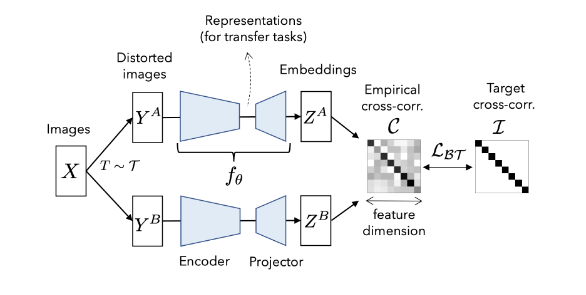

In [33]:
###########################
##### Helper Function #####
###########################
class BarlowTwins(nn.Module):
    '''
    Full Barlow Twins model with encoder, projector and loss
    '''
    def __init__(self, encoder, projector, lambd):
        '''
        :param encoder: encoder network
        :param projector: projector network
        :param lambd: tradeoff function (hyper-parameter)
        '''
        super().__init__()
        self.encoder = encoder
        self.projector = projector
        self.lambd = lambd     

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(128, affine=False)

    def forward(self, y1, y2):
        z1 = self.encoder(y1)
        z2 = self.encoder(y2)
        z1 = self.projector(z1)
        z2 = self.projector(z2)
        return barlow_loss(z1, z2, self.bn, self.lambd)

The following transform performs the pair of augmentations on the input data of the model.

In [34]:
###########################
##### Helper Function #####
###########################
cifar_train_mean = [125.30691805, 122.95039414, 113.86538318]
cifar_train_std = [62.99321928, 62.08870764, 66.70489964]

class Transform:
    def __init__(self, t1, t2):
        '''
        :param t1: Transforms to be applied to first input
        :param t2: Transforms to be applied to second input
        '''
        self.t1 = transforms.Compose([
                t1,
                transforms.ToTensor(),
                transforms.Normalize(mean=cifar_train_mean, std=cifar_train_std)
            ])
        self.t2 = transforms.Compose([
                t2,
                transforms.ToTensor(),
                transforms.Normalize(mean=cifar_train_mean, std=cifar_train_std)
            ])

    def __call__(self, x):
        y1 = self.t1(x)
        y2 = self.t2(x)
        return y1, y2

### Training

With all the components complete, we are now ready to start our self-supervised training! In the next cell, the four constants at the top are the training hyper-parameters. Depending on your resource avaliability, you may be able to increase the number of epochs for better final results. The default configuration of 10 epochs should take less than 10 minutes to finish training on a GPU.

In [35]:
# Hyper-parameters
EPOCHS = 10
LR = 0.001
BATCH = 256
LAMBDA = 5e-3

# Initialize encoder, projector and full model
encoder = models.resnet18(pretrained=False)
encoder.fc = nn.Identity() # removes the 1000-dimensional classification layer
projector = Projector()
twins = BarlowTwins(encoder, projector, LAMBDA).cuda()
# Dataset and optimizer
dataset = datasets.CIFAR10(root='./data', train=True, transform=Transform(t1, t2))
loader = DataLoader(dataset,
                    batch_size=BATCH,
                    num_workers=0,      # you can set more if you have enough shm, or the iteration will hang up
                    shuffle=True)
optimizer = torch.optim.Adam(twins.parameters(), lr=LR)
# Training loop
for epoch in range(EPOCHS):
    for ((x1,x2), _) in loader:
        loss = twins(x1.cuda(), x2.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch + 1}, Loss: {float(loss)}")

d:\Miniconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Miniconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Loss: 8.498335838317871
Epoch: 2, Loss: 6.795036315917969
Epoch: 3, Loss: 7.080327033996582
Epoch: 4, Loss: 5.565235614776611
Epoch: 5, Loss: 5.381019115447998
Epoch: 6, Loss: 4.834549427032471
Epoch: 7, Loss: 6.072295188903809
Epoch: 8, Loss: 4.482099533081055
Epoch: 9, Loss: 4.523290634155273
Epoch: 10, Loss: 4.385496139526367


## k-NN with self-supervised features

We will now use our trained ResNet-18 encoder to extract features for the k-NN classifier.

In [36]:
# Dataloaders for extracting self-supervised features
test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=cifar_train_mean, std=cifar_train_std)
            ])

train_set = datasets.CIFAR10(root='./data', train=True, transform=test_transform)
val_set = datasets.CIFAR10(root='./data', train=False, transform=test_transform)

train_subset_torch = torch.utils.data.Subset(train_set, train_indices)
val_subset_torch = torch.utils.data.Subset(val_set, val_indices)

train_loader = torch.utils.data.DataLoader(train_subset_torch,
                                        batch_size=NUM_SAMPLES,
                                        shuffle=False)
val_loader = torch.utils.data.DataLoader(val_subset_torch,
                                        batch_size=NUM_SAMPLES,
                                        shuffle=False)

# Extract features with the trained encoder
# We use a single batch of size 1000
for batch in train_loader:
    train_features = encoder(batch[0].cuda()).data.cpu().numpy()

for batch in val_loader:
    val_features = encoder(batch[0].cuda()).data.cpu().numpy()

### Final Prediction

Now that we run our k-NN classifier on top of the learned features rather than the raw image pixels, we expect a boost in classification accuracy.

In [37]:
predictions_7 = []
predictions_13 = []
predictions_19 = []
for sample in val_features:
    predictions_7.append(predict_knn(sample, train_features, train_subset_labels, k=7))
    predictions_13.append(predict_knn(sample, train_features, train_subset_labels, k=13))
    predictions_19.append(predict_knn(sample, train_features, train_subset_labels, k=19))

C:\Users\86156\AppData\Local\Temp\ipykernel_31652\1221243924.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance = torch.sum(torch.tensor(abs(train_data - sample).reshape(n, -1)), dim=-1, keepdim=False)      # reshape to (n, ?) before sum


In [38]:
matches_7 = (np.array(predictions_7) == val_subset_labels)
accuracy_7 = np.sum(matches_7)/NUM_SAMPLES * 100
print(f"k-NN accuracy (k=7): {accuracy_7}%")

matches_13 = (np.array(predictions_13) == val_subset_labels)
accuracy_13 = np.sum(matches_13)/NUM_SAMPLES * 100
print(f"k-NN accuracy (k=13): {accuracy_13}%")

matches_19 = (np.array(predictions_19) == val_subset_labels)
accuracy_19 = np.sum(matches_19)/NUM_SAMPLES * 100
print(f"k-NN accuracy (k=19): {accuracy_19}%")

k-NN accuracy (k=7): 27.200000000000003%
k-NN accuracy (k=13): 30.099999999999998%
k-NN accuracy (k=19): 30.0%


Congratulations! You have now implemented a state-of-the-art method for self-supervised learning, and with that completed the final exercise of this computer vision course. We hope you enjoyed the exercises. Good luck for your exams!